# Multivariable Logistic Regression (Example 5.2)

This notebook is based on `tests/exp_multivariable_logistic_regression.py`.

- Shared helpers are defined once and reused.
- The Mushrooms and W8A experiments are split into separate sections.

In [6]:
import numpy as np
import autograd.numpy as anp
import matplotlib.pyplot as plt

from matplotlib.ticker import LogFormatterMathtext

from algorithms.datasets.libsvm_loader import load_mushrooms, load_w8a
from algorithms import GDA, GD, Nesterov

## Helpers

In [7]:
def to_binary01(y: np.ndarray) -> np.ndarray:
    """Convert various binary labels to {0,1}."""
    y = np.asarray(y).ravel().astype(np.float64)
    uniq = np.unique(y)
    if uniq.size != 2:
        raise ValueError(f"Expected binary labels, got {uniq}")

    s = set(uniq.tolist())
    if s == {1.0, 2.0}:
        return (y - 1.0).astype(np.int64)
    if s == {-1.0, 1.0}:
        return ((y + 1.0) * 0.5).astype(np.int64)
    if s == {0.0, 1.0}:
        return y.astype(np.int64)

    lo, hi = uniq[0], uniq[1]
    return (y == hi).astype(np.int64)

def get_lipchitz_coefficient(A: np.ndarray) -> float:
    """Paper (Sec 5.2) estimate: L = 1/(2N) * (||A||^2/2 + 1).

    Here ||A|| is the spectral/operator 2-norm.
    """
    A = np.asarray(A, dtype=np.float64)
    n = A.shape[0]
    s = np.linalg.norm(A, 2) ** 2 / 2 + 1  # spectral norm squared
    return 1.0 / (2 * n) * s


def make_objective(A: np.ndarray, y01: np.ndarray, l2: float):
    """Make a stable binary logistic loss function

    Args:
        A (np.ndarray): The data matrix
        y01 (np.ndarray): The binary labels in {0,1}
        l2 (float): The L2 regularization coefficient

    Returns:
        callable: A function that computes the stable binary logistic loss
    """
    A_ag = anp.array(np.asarray(A, dtype=np.float64))
    y_ag = anp.array(np.asarray(y01, dtype=np.float64)).ravel()

    def f(w: anp.ndarray) -> anp.float64:
        z = A_ag @ w
        logsig = -anp.logaddexp(0.0, -z)
        loss = anp.mean((1.0 - y_ag) * z - logsig)
        reg = 0.5 * l2 * anp.dot(w, w)
        return loss + reg

    return f


def accuracy(A: np.ndarray, b01: np.ndarray, w: np.ndarray) -> float:
    """Calculate the accuracy of predictions made by logistic model.

    Args:
        A (np.ndarray): The data matrix
        b01 (np.ndarray): The binary labels in {0,1}
        w (np.ndarray): The weight vector

    Returns:
        float: The accuracy of the model's predictions
    """
    logits = np.asarray(A, dtype=np.float64) @ np.asarray(w, dtype=np.float64)
    pred01 = (logits >= 0.0).astype(np.int64)
    return float(np.mean(pred01 == b01))


# -----------------------------
# 5) Convergence iteration
# -----------------------------
def first_k_reach_eps(curve: np.ndarray, eps: float) -> int:
    idx = np.where(curve <= eps)[0]
    return int(idx[0]) if idx.size > 0 else -1


def format_vector(x: np.ndarray, max_len: int = 12) -> str:
    x = np.asarray(x, dtype=np.float64).ravel()
    if x.size <= max_len:
        return np.array2string(x, precision=4, suppress_small=False)
    head = x[:max_len]
    return (
        np.array2string(head, precision=4, suppress_small=False)
        + f", ... (d={x.size})"
    )

def apply_log_axis(ax):
    ticks = [1e1, 1e-2, 1e-5, 1e-8, 1e-11, 1e-14, 1e-17]
    ax.set_yscale("log")
    ax.set_ylim(1e-14, 1e1)
    ax.set_yticks(ticks)
    ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
    ax.minorticks_off()
    ax.grid(True, which="major", alpha=0.35)
    ax.grid(False, which="minor")

## Core Experiment Runner

In [8]:
def run_dataset(dataset: str, it_max=4000, tol: float = 1e-11):
    ds = dataset.lower().strip()
    if ds == "mushrooms":
        A, y_raw = load_mushrooms()
    elif ds == "w8a":
        A, y_raw = load_w8a(train=True)
    else:
        raise ValueError("dataset must be 'mushrooms' or 'w8a'")

    A = np.asarray(A, dtype=np.float64)
    b01 = to_binary01(y_raw)

    n, d = A.shape

    # Paper (Sec 5.2): J̄(w) = J(w) + (1/(2N))||w||^2, so l2 = 1/N in (l2/2)||w||^2
    L = get_lipchitz_coefficient(A)  # paper's estimate using ||A||_2
    l2 = 1.0 / n
    f = make_objective(A, b01, l2)

    print(f"\nDataset={dataset}  n={n}  d={d}  it_max={it_max}")
    print(f"L (paper estimate) = {L}")
    print(f"l2 (reg) = {l2}")

    w0 = np.zeros(d, dtype=np.float64)

    eye_projector = lambda x: x  # identity projector for unconstrained case

    print("\n=== RUNS ===")

    print("Running GD...")
    gd = GD(function=f, projector=eye_projector)
    res_gd = gd.solve(x0=w0, step_size=1 / L, max_iter=int(it_max), stop_if_stationary=False, with_f_history=True, with_tqdm=True)
    print("Compute f values for GD...")
    vals_gd = np.array(res_gd.f_history)
    print("GD done.")

    print("Running Nesterov...")
    nest = Nesterov(function=f, projector=eye_projector)
    res_ne = nest.solve(x0=w0, step_size=1/L, max_iter=int(it_max), stop_if_stationary=False, with_f_history=True, with_tqdm=True)
    print("Compute f values for Nesterov...")
    vals_ne = np.array(res_ne.f_history)
    print("Nesterov done.")

    gda_runs = []
    for kappa in (0.75, 0.85, 0.95):
        print(f"Running GDA with kappa={kappa}...")
        gda = GDA(function=f, projector=eye_projector)
        res = gda.solve(
            x0=w0,
            lambda_0=1000.0,
            sigma=0.1,
            kappa=kappa,
            max_iter=int(it_max),
            stop_if_stationary=False,
            with_f_history=True,
            with_tqdm=True,
            with_lr_history=True,
        )
        print(f"Compute f values for GDA with kappa={kappa}...")
        vals = np.array(res.f_history)
        print(f"GDA with kappa={kappa} done.\n")
        gda_runs.append((kappa, res, vals))

    # best found f*
    f_star = float(np.min(np.concatenate([vals_gd, vals_ne] + [vals for _, _, vals in gda_runs])))

    gd_curve = vals_gd - f_star
    ne_curve = vals_ne - f_star
    gda_curves = [(kappa, vals - f_star) for kappa, _, vals in gda_runs]

    k_gd = first_k_reach_eps(gd_curve, tol)
    k_ne = first_k_reach_eps(ne_curve, tol)

    
    # Compute accuracies first so we can include them in the table
    gd_acc = float(accuracy(A, b01, res_gd.x_opt))
    ne_acc = float(accuracy(A, b01, res_ne.x_opt))
    gda_accs = []
    for kappa, res, _ in gda_runs:
        acc = float(accuracy(A, b01, res.x_opt))
        gda_accs.append((kappa, acc))

    rows = [
        ("GD", k_gd, float(vals_gd[-1]), gd_acc, ""),
        ("Nesterov", k_ne, float(vals_ne[-1]), ne_acc, ""),
    ]

    for (kappa, res, vals), (_, curve) in zip(gda_runs, gda_curves):
        k_gda = first_k_reach_eps(curve, tol)
        acc = next(a for kk, a in gda_accs if kk == kappa)
        rows.append((f"GDA (k={kappa})", k_gda, float(vals[-1]), acc, f"{kappa}"))

    # Pretty table (no extra dependencies)
    name_w = max(len(r[0]) for r in rows)
    k_w = max(len("k_conv"), max(len(str(r[1])) for r in rows))
    f_w = max(len("f(x*)"), max(len(f"{r[2]:.16e}") for r in rows))
    a_w = max(len("acc"), max(len(f"{r[3]:.6f}") for r in rows))

    header = f"{'Method':<{name_w}}  {'k_conv':>{k_w}}  {'f(x*)':>{f_w}}  {'acc':>{a_w}}"
    sep = "-" * len(header)
    print(sep)
    print(header)
    print(sep)
    for name, kconv, fval, acc, _ in rows:
        print(f"{name:<{name_w}}  {kconv:>{k_w}d}  {fval:>{f_w}.16e}  {acc:>{a_w}.6f}")
    print(sep)

    # ---------------- PLOT ----------------
    plt.figure(figsize=(7, 5), dpi=300)
    ax = plt.gca()
    apply_log_axis(ax)

    ax.plot(gd_curve, label="GD", linewidth=2.0)
    ax.plot(
        ne_curve,
        label="Nesterov",
        linewidth=2.0,
        marker="o",
        markevery=250,
        markersize=4,
    )
    for kappa, curve in gda_curves:
        ax.plot(
            curve,
            label=f"GDA (k={kappa})",
            linewidth=2.0,
            marker="*",
            markevery=250,
            markersize=5,
        )

    ax.set_xlabel("Iteration")
    ax.set_ylabel(r"$f(w^k) - f_{\ast}$")
    ax.set_title(f"Example 5.2 logistic regression: {dataset}")
    ax.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

    ### PLOT Learning rate history for GDA runs
    plt.figure(figsize=(7, 5), dpi=300)
    ax = plt.gca()
    for kappa, res, _ in gda_runs:
        if res.lr_history is not None:
            ax.plot(
                res.lr_history,
                label=f"GDA (k={kappa})",
                linewidth=2.0,
                marker="*",
                markevery=250,
                markersize=5,
            )
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Learning rate")
    ax.set_title(f"GDA learning rate history: {dataset}")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    return res_gd, res_ne, gda_runs, f_star

## Mushrooms


Dataset=mushrooms  n=8124  d=112  it_max=4000
L (paper estimate) = 2.5862757799409035
l2 (reg) = 0.00012309207287050715

=== RUNS ===
Running GD...


Compute f values for GD...
GD done.
Running Nesterov...


Compute f values for Nesterov...
Nesterov done.
Running GDA with kappa=0.75...


Compute f values for GDA with kappa=0.75...
GDA with kappa=0.75 done.

Running GDA with kappa=0.85...


Compute f values for GDA with kappa=0.85...
GDA with kappa=0.85 done.

Running GDA with kappa=0.95...


Compute f values for GDA with kappa=0.95...
GDA with kappa=0.95 done.

------------------------------------------------------
Method        k_conv                   f(x*)       acc
------------------------------------------------------
GD                -1  1.6327342363323036e-02  0.999138
Nesterov          -1  1.4485898097961698e-02  1.000000
GDA (k=0.75)    2408  1.4485866128335448e-02  1.000000
GDA (k=0.85)    2314  1.4485866128334988e-02  1.000000
GDA (k=0.95)    2938  1.4485866128335230e-02  1.000000
------------------------------------------------------


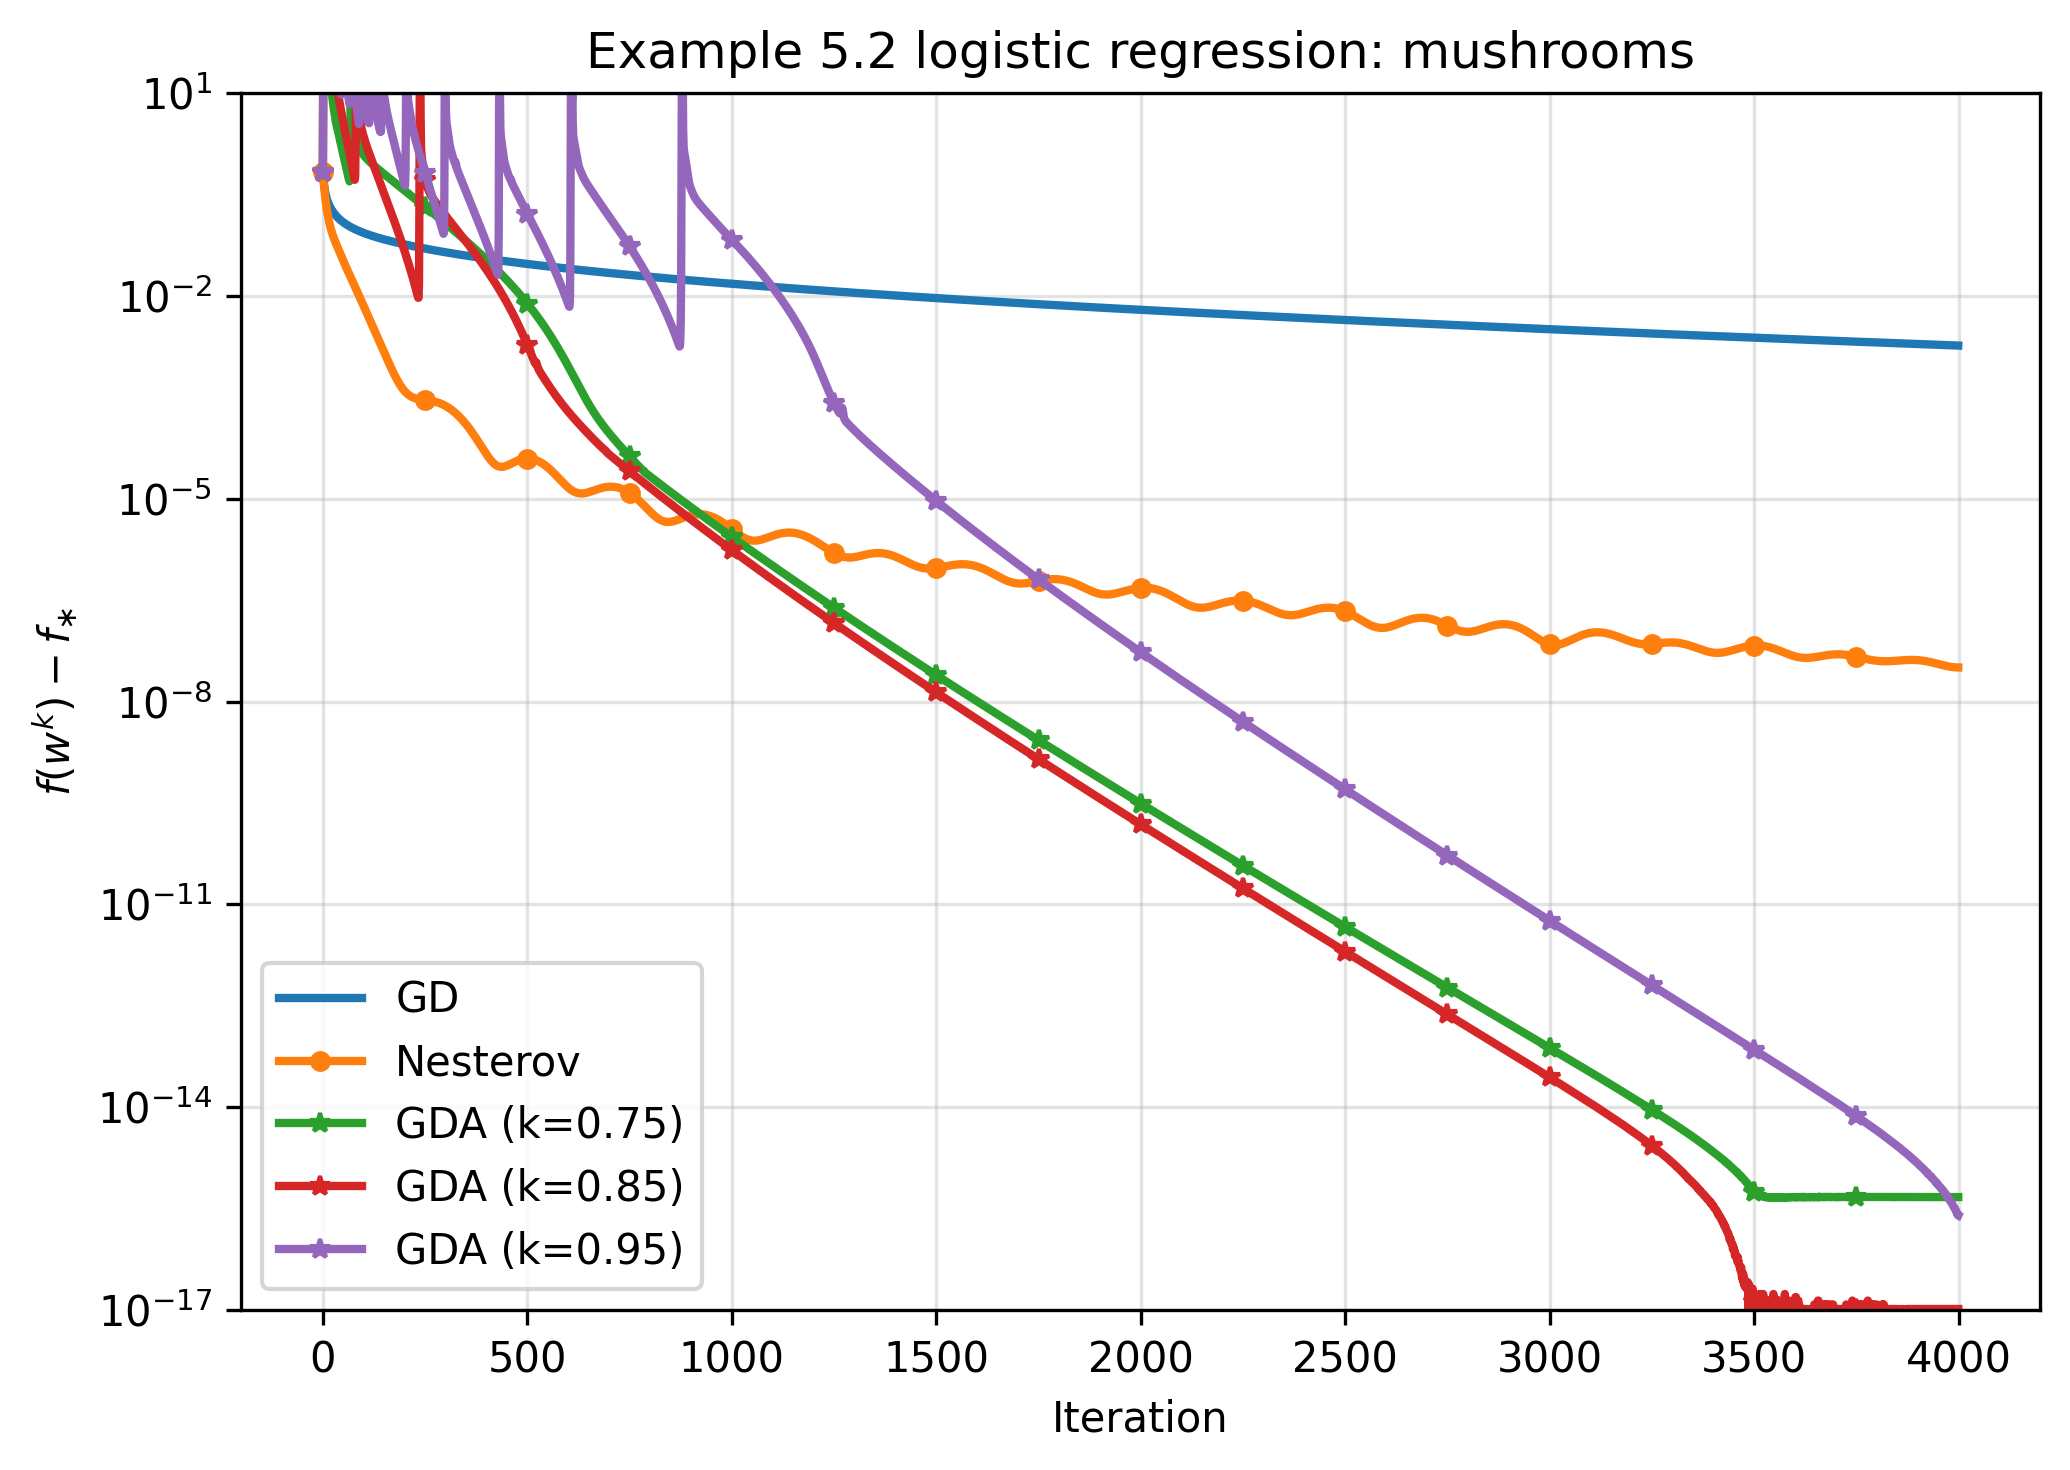

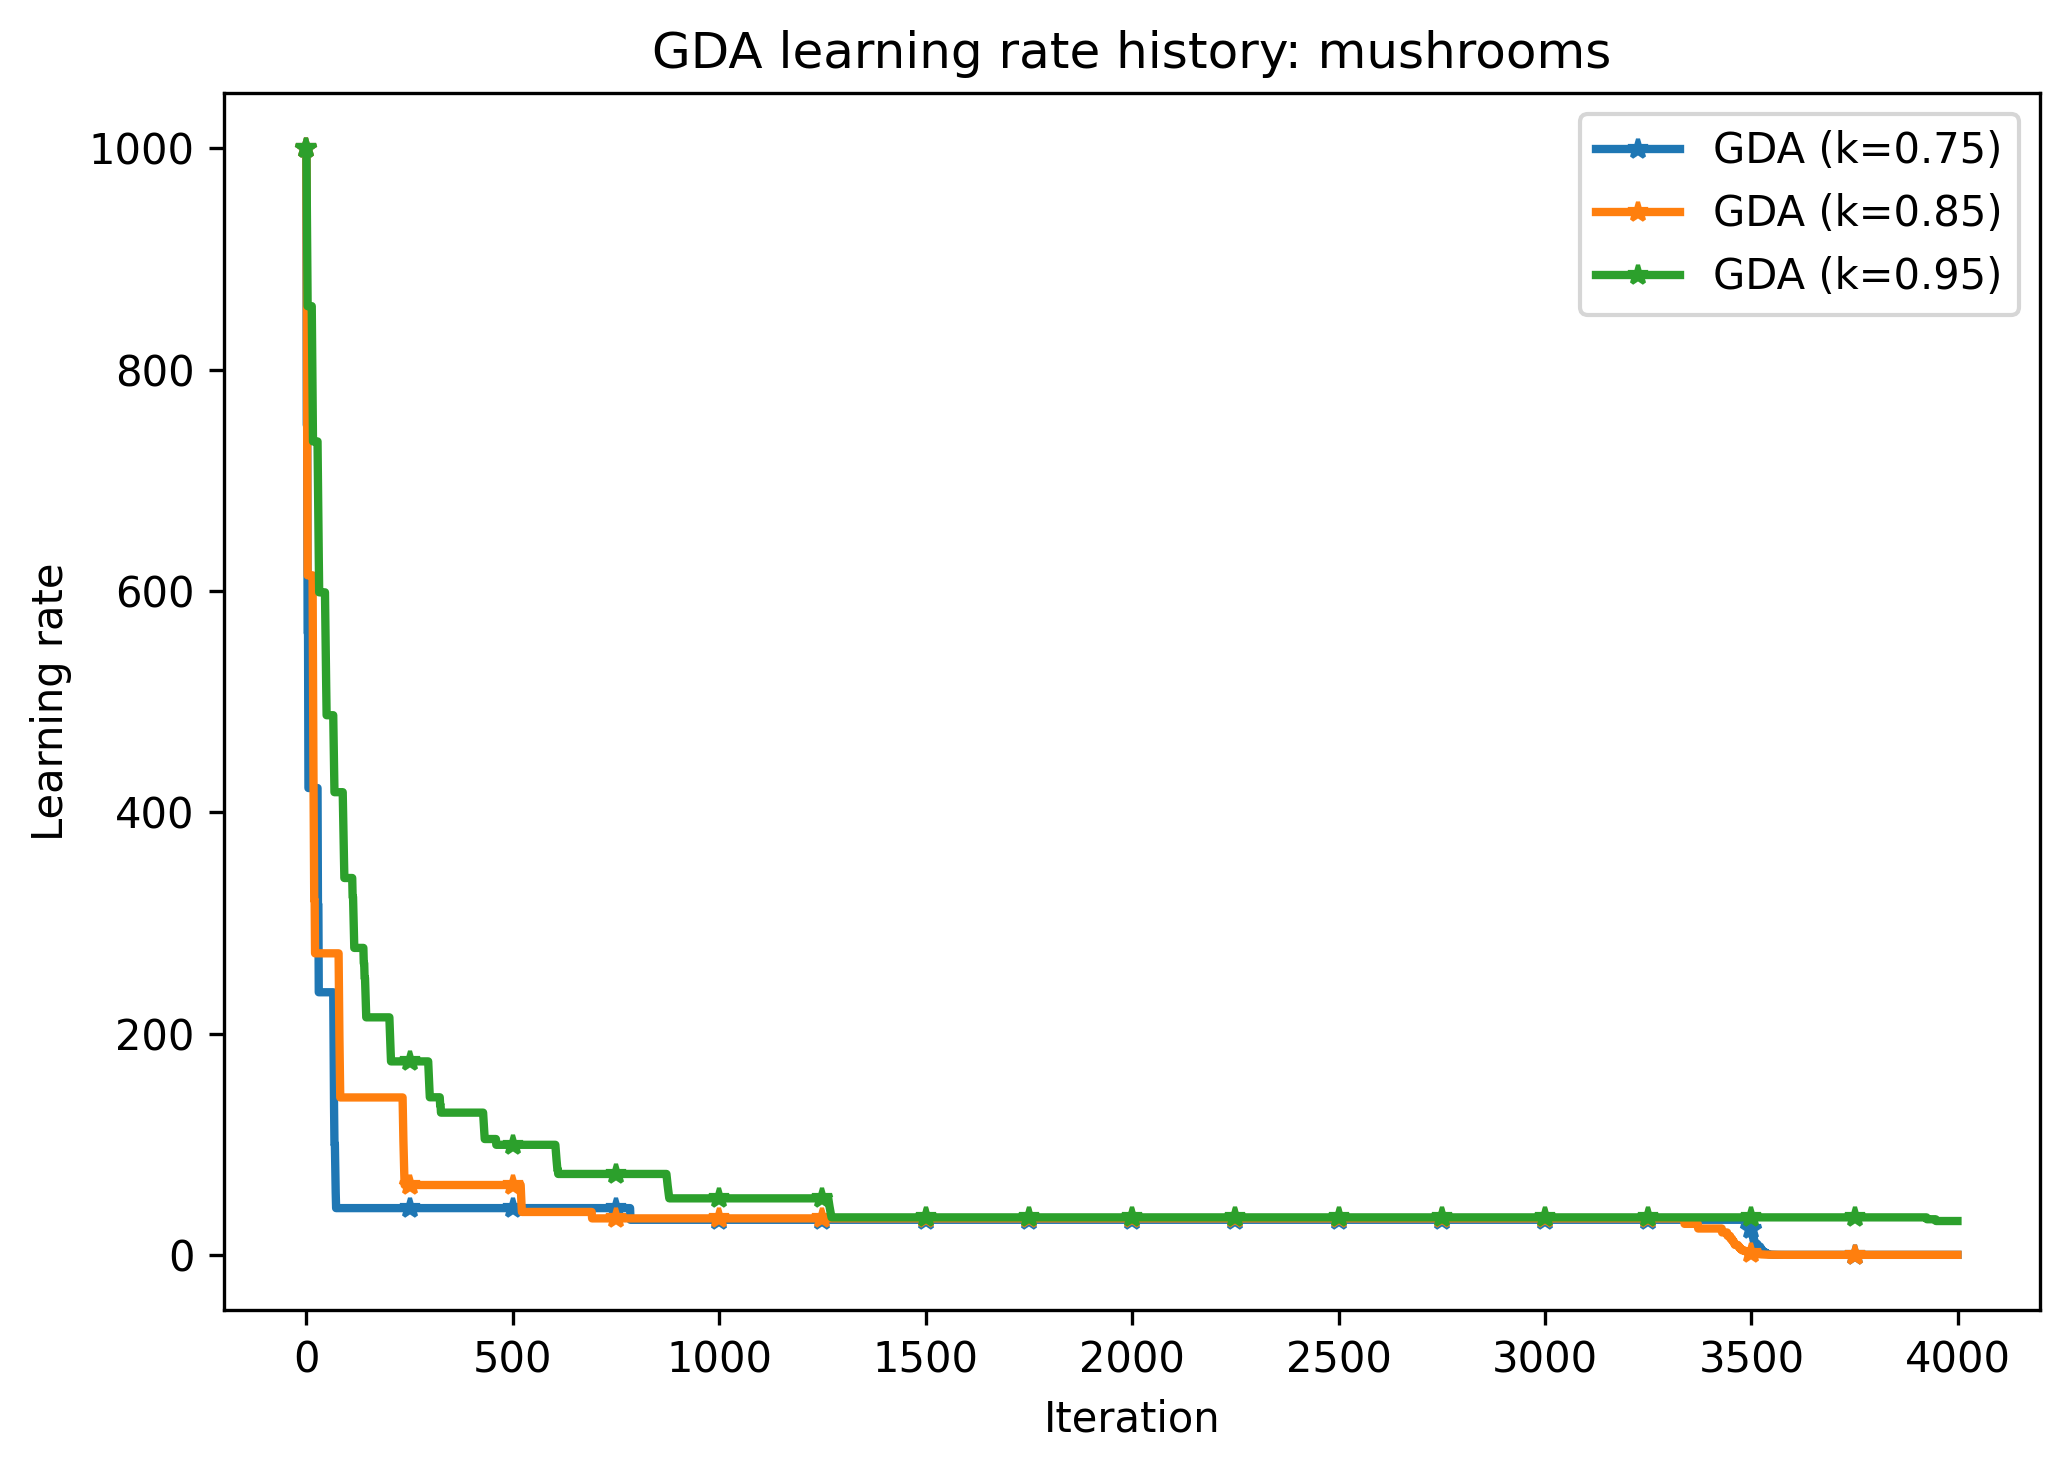

In [9]:
mushrooms = run_dataset("mushrooms", it_max=4000, tol=1e-11)

## W8A


Dataset=w8a  n=49749  d=300  it_max=4000
L (paper estimate) = 0.6612094349477562
l2 (reg) = 2.0100906550885444e-05

=== RUNS ===
Running GD...


Compute f values for GD...
GD done.
Running Nesterov...


Compute f values for Nesterov...
Nesterov done.
Running GDA with kappa=0.75...


Compute f values for GDA with kappa=0.75...
GDA with kappa=0.75 done.

Running GDA with kappa=0.85...


Compute f values for GDA with kappa=0.85...
GDA with kappa=0.85 done.

Running GDA with kappa=0.95...


Compute f values for GDA with kappa=0.95...
GDA with kappa=0.95 done.

------------------------------------------------------
Method        k_conv                   f(x*)       acc
------------------------------------------------------
GD                -1  1.3220869624087078e-01  0.903254
Nesterov          -1  1.2618086727841837e-01  0.905807
GDA (k=0.75)    1868  1.2618068651051506e-01  0.905787
GDA (k=0.85)    1696  1.2618068651051470e-01  0.905787
GDA (k=0.95)    1551  1.2618068651051378e-01  0.905787
------------------------------------------------------


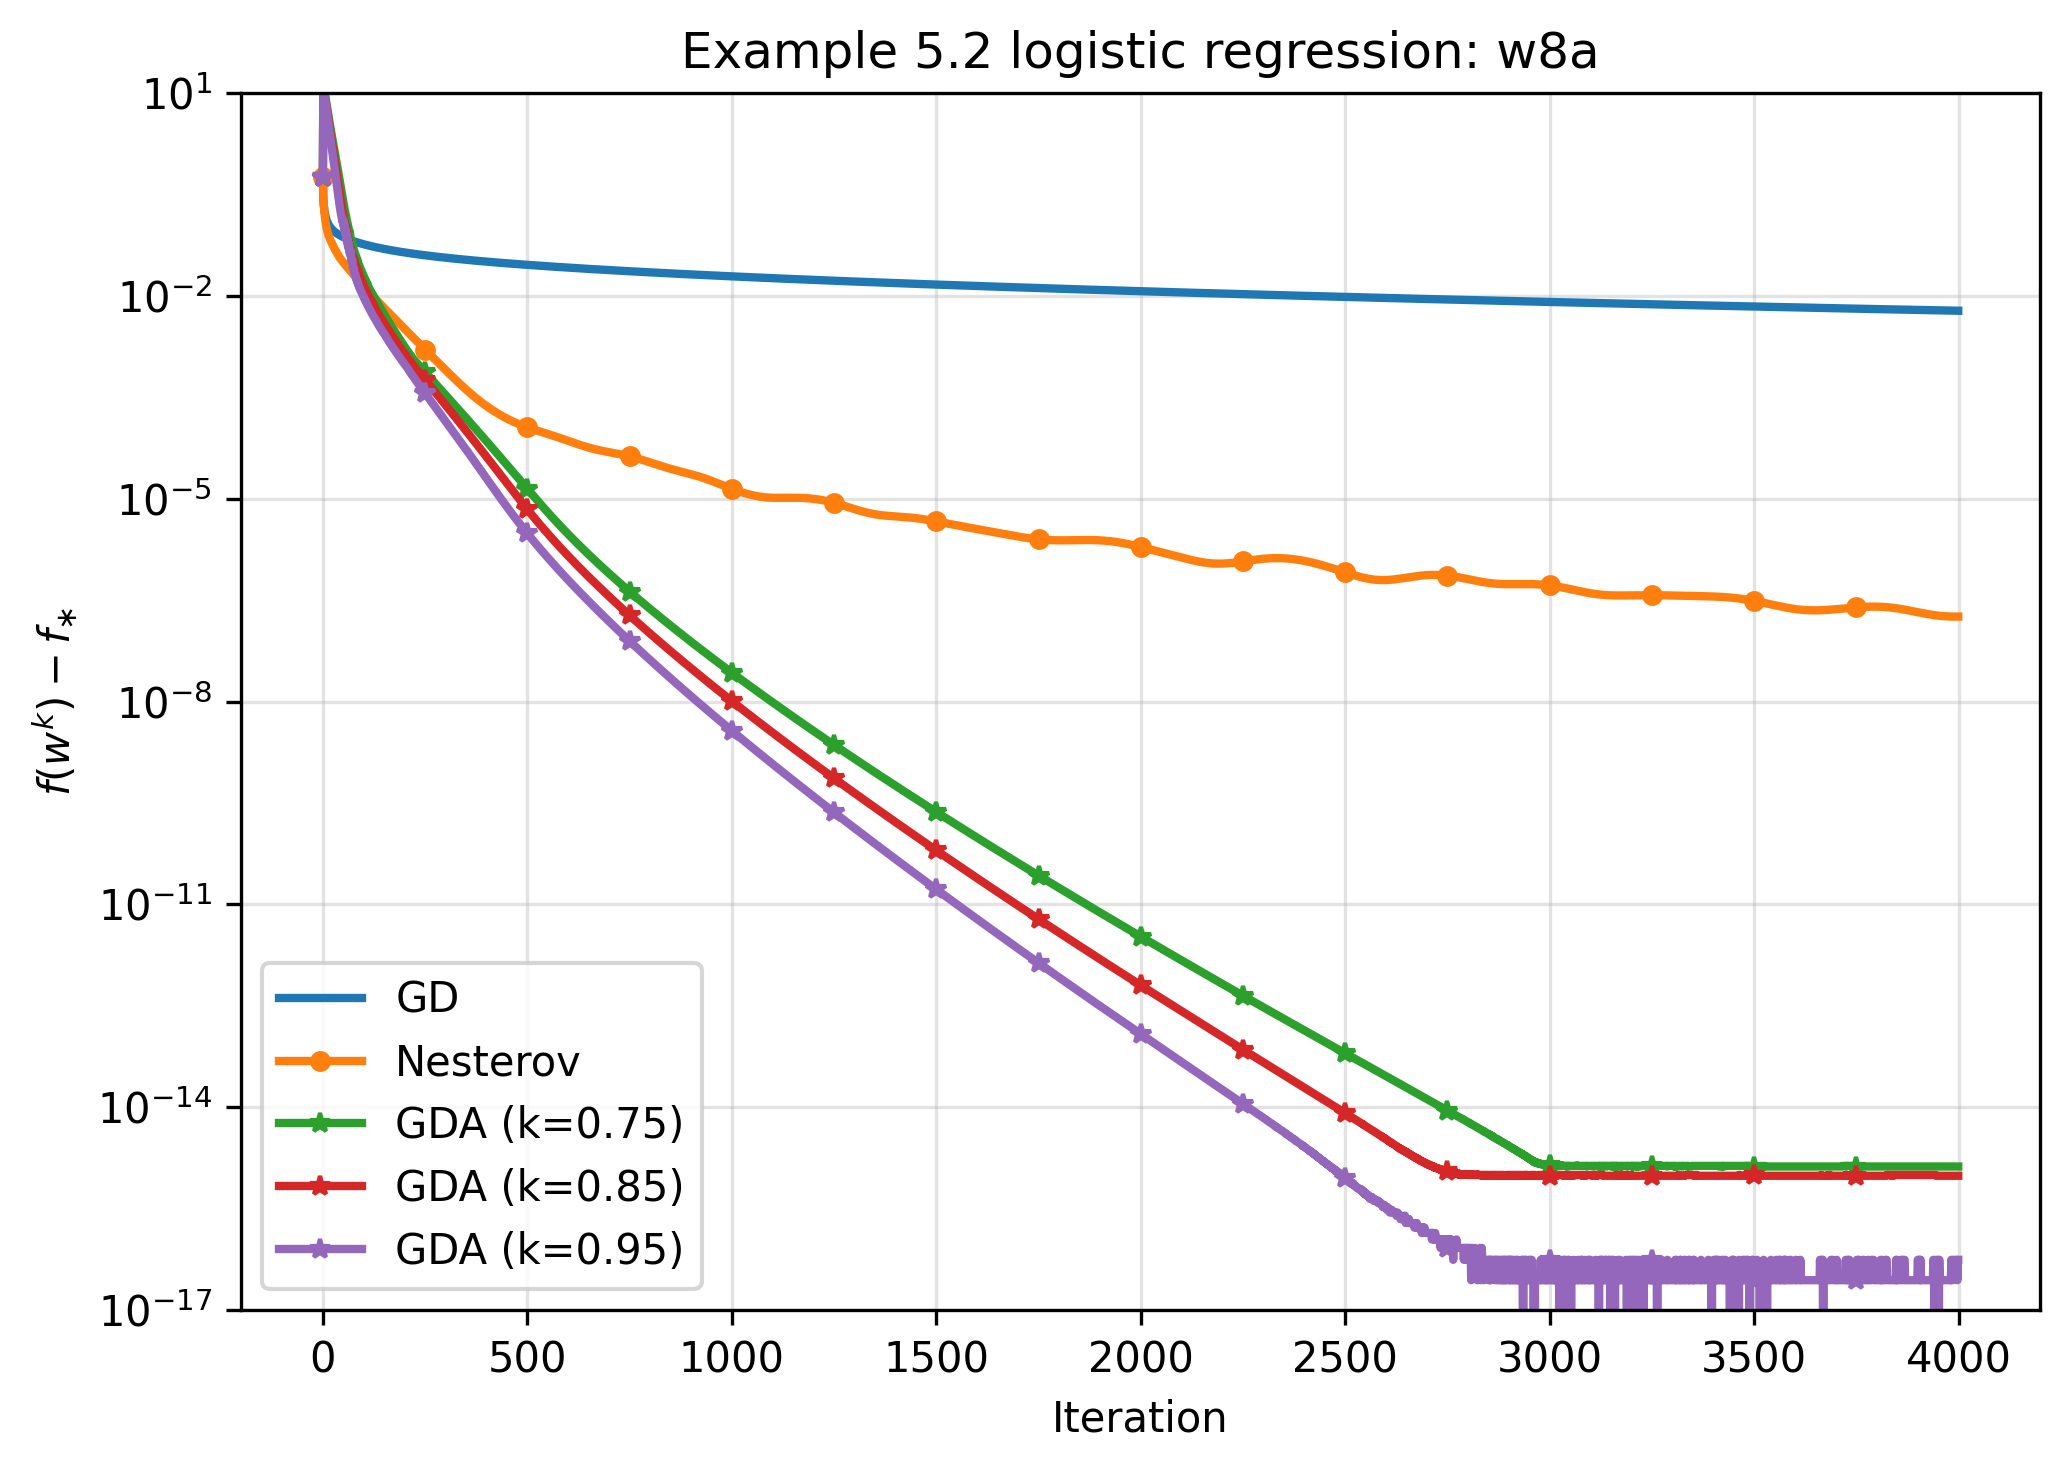

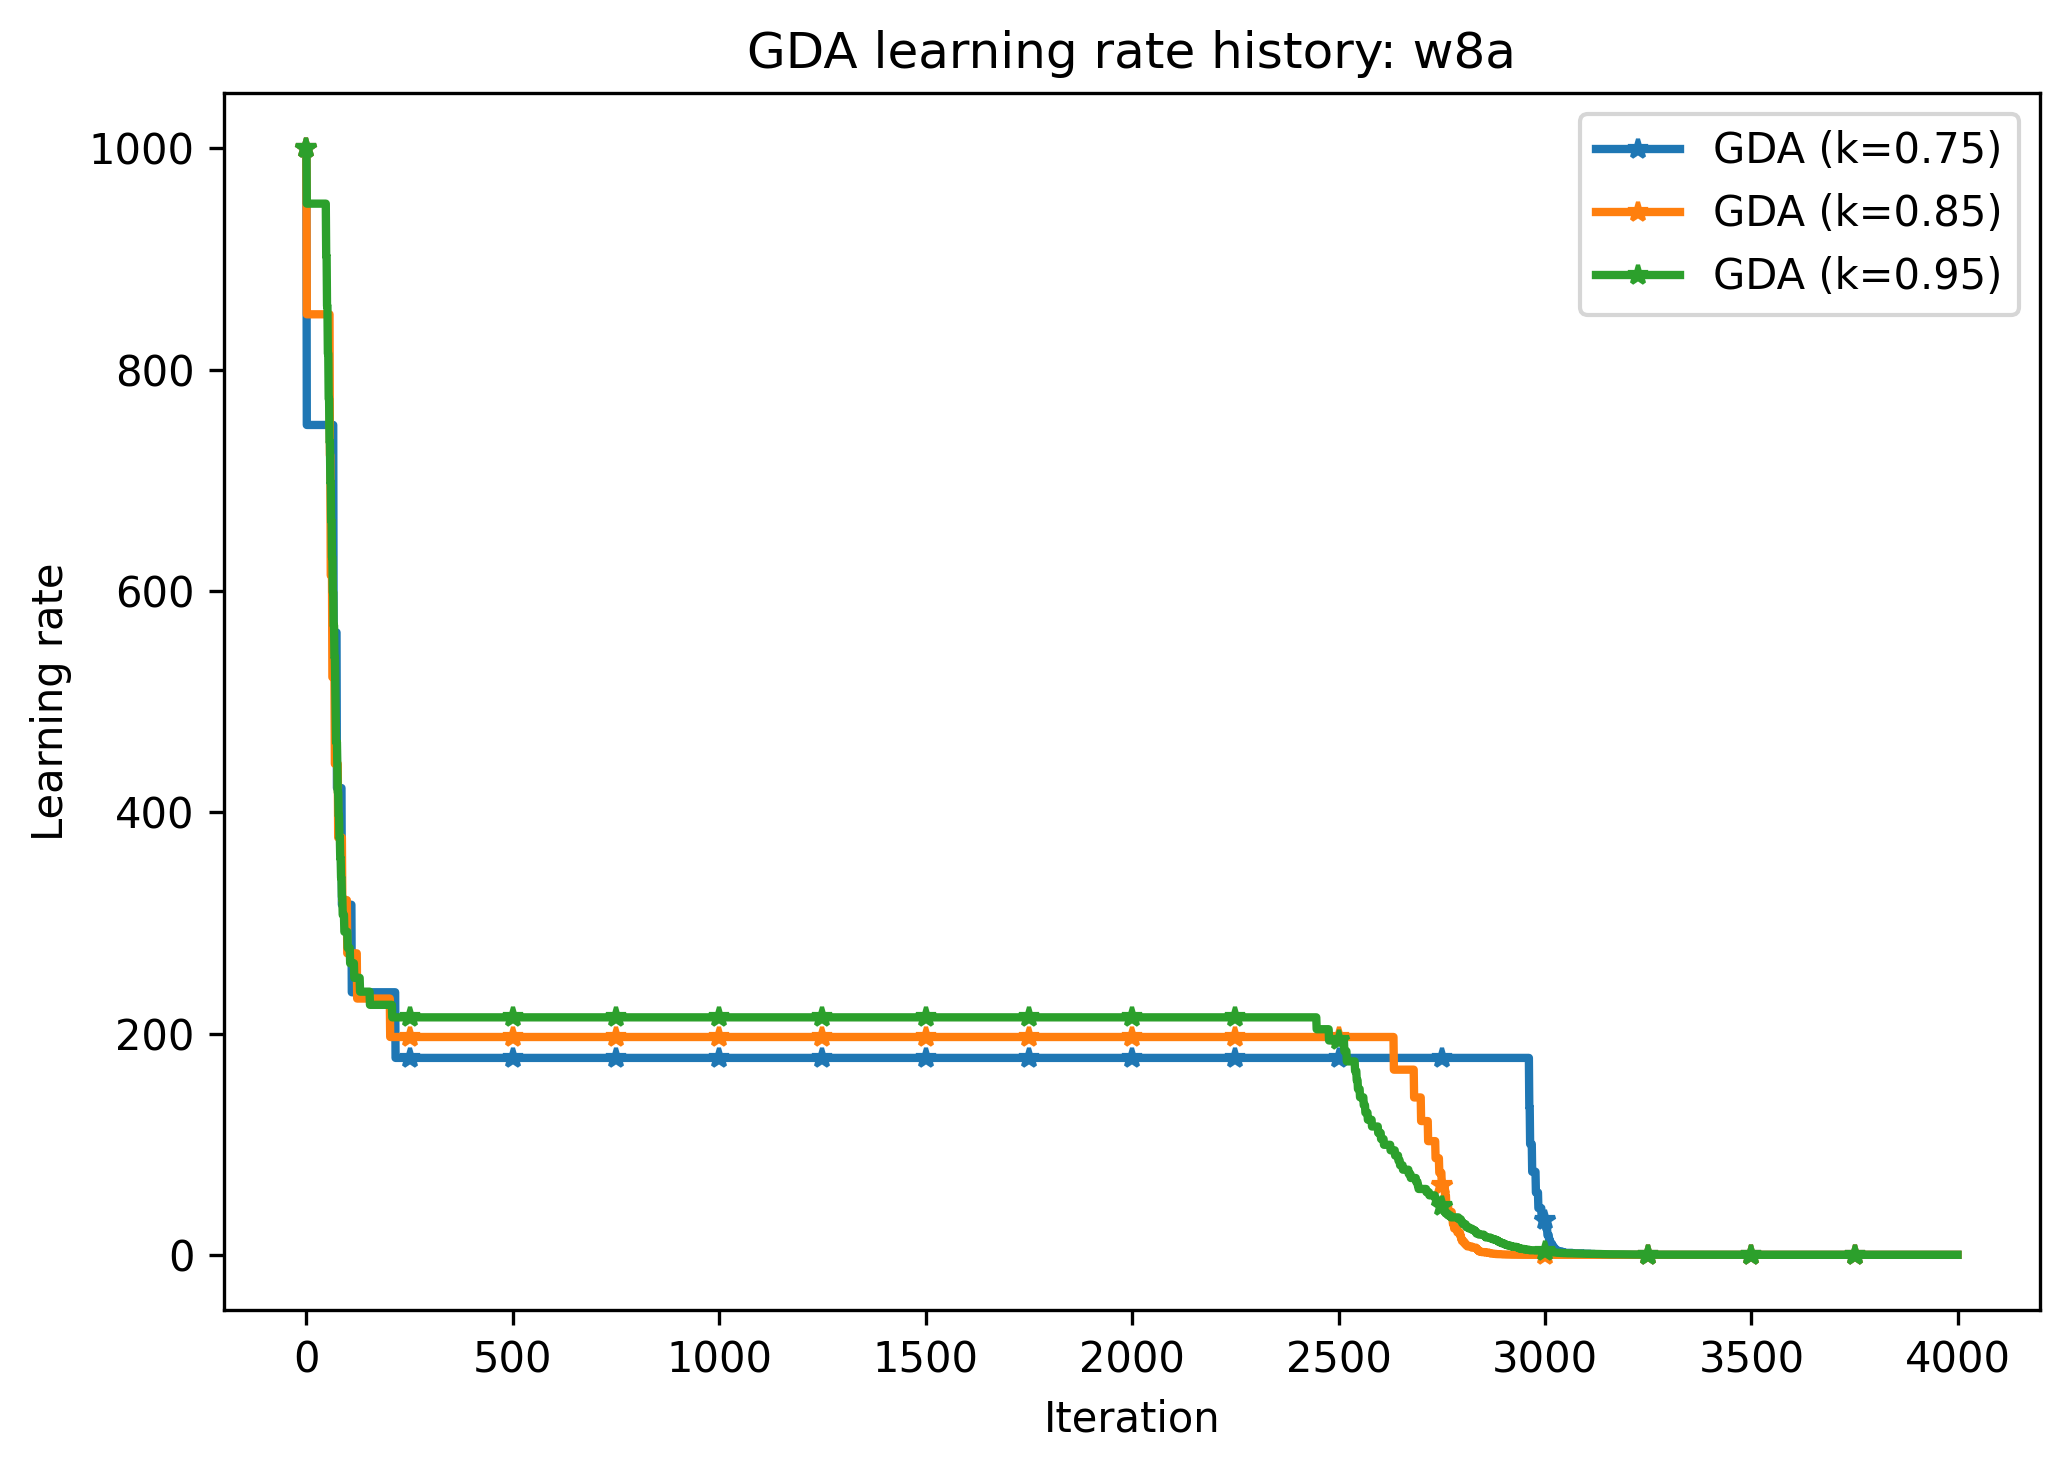

In [10]:
w8a = run_dataset("w8a", it_max=4000, tol=1e-11)